In [ ]:
import pickle

# nlp
!conda install -c conda-forge bertopic
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# visualizations
!conda install -c conda-forge plotly
!conda install -c conda-forge python-kaleido


In [3]:
import os
from bertopic import BERTopic
from tqdm import tqdm
import pandas as pd
from nltk.corpus import stopwords as stop_words
from datetime import datetime
from IPython.display import SVG, HTML, Image, display
import pickle

In [10]:
base_dir = "C:/Users/Boulanger/ownCloud/Langfristvorhaben/Legal-Theory-Graph/Data"
corpus_dir = os.path.join(base_dir, "FULLTEXTS/JLS/jls-txt")
d2y = pd.read_csv('data/jls-doi-to-year.csv')
stopwords=set(stop_words.words('english'))
stopwords.update({'jstor','conditions','terms','use','content','de','la'})

In [11]:
# Load the articles
articles = []
timestamps = []
not_found = []
for filename in tqdm(os.listdir(corpus_dir)):
    if filename.endswith(".txt"):
        with open(os.path.join(corpus_dir, filename), "r", encoding="utf-8") as f:
            article = f.read()
            tmp_article = []
            doi = filename.strip(".txt").replace("_","/")
            year = d2y.loc[d2y['DOI'] == doi, 'year']
            if year.empty:
                year = d2y.loc[d2y['DOI'] == f"{doi}.x", 'year']
            # only use articles for which we have a year
            if not year.empty:
                timestamp = datetime.strptime(str(year.values[0]), '%Y').date()
                timestamps.append(timestamp)
                for word in str(article).split():
                    if word.lower() not in stopwords and not word.isnumeric():
                        tmp_article.append(word)
                articles.append(' '.join(tmp_article))
            else:
                not_found.append(doi)

earliest_year = min(timestamps).strftime('%Y')
latest_year = max(timestamps).strftime('%Y')

print(f"Corpus has {len(articles)} articles from {earliest_year} to {latest_year}. Date information is missing for {len(not_found)} articles.")

100%|██████████| 1650/1650 [00:09<00:00, 170.39it/s]

Corpus has 1564 articles from 1974 to 2021. Date information is missing for 86 articles.


In [12]:
model: BERTopic = BERTopic(verbose=True)
topics, probs = model.fit_transform(articles)
# persist model data for later use
with open('cache/bertopic-data.pkl', 'wb') as file:
    pickle.dump((model, topics, probs, timestamps, articles), file)

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

2023-05-25 22:48:09,512 - BERTopic - Transformed documents to Embeddings
2023-05-25 22:48:19,733 - BERTopic - Reduced dimensionality
2023-05-25 22:48:19,818 - BERTopic - Clustered reduced embeddings


You can skip the following step if you have just generated the data and start here if you have already generated it earlier:

In [7]:
if 'model' not in locals():
    # Load the model data from disk.
    with open('cache/bertopic-data.pkl', 'rb') as file:
        model, topics, probs, timestamps, articles = pickle.load(file)

In [18]:
model.get_topic_info()

,Topic,Count,Name
0,-1,429,-1_law_legal_social_see
1,0,196,0_law_legal_social_sociology
2,1,92,1_children_family_child_parents
3,2,76,2_education_law_legal_students
4,3,51,3_regulatory_regulation_safety_public
5,4,40,4_women_feminist_gender_law
6,5,38,5_law_economic_legal_economics
7,6,37,6_government_state_local_public
8,7,36,7_rape_sexual_justice_restorative
9,8,35,8_ireland_northern_irish_political


48it [01:18,  1.64s/it]


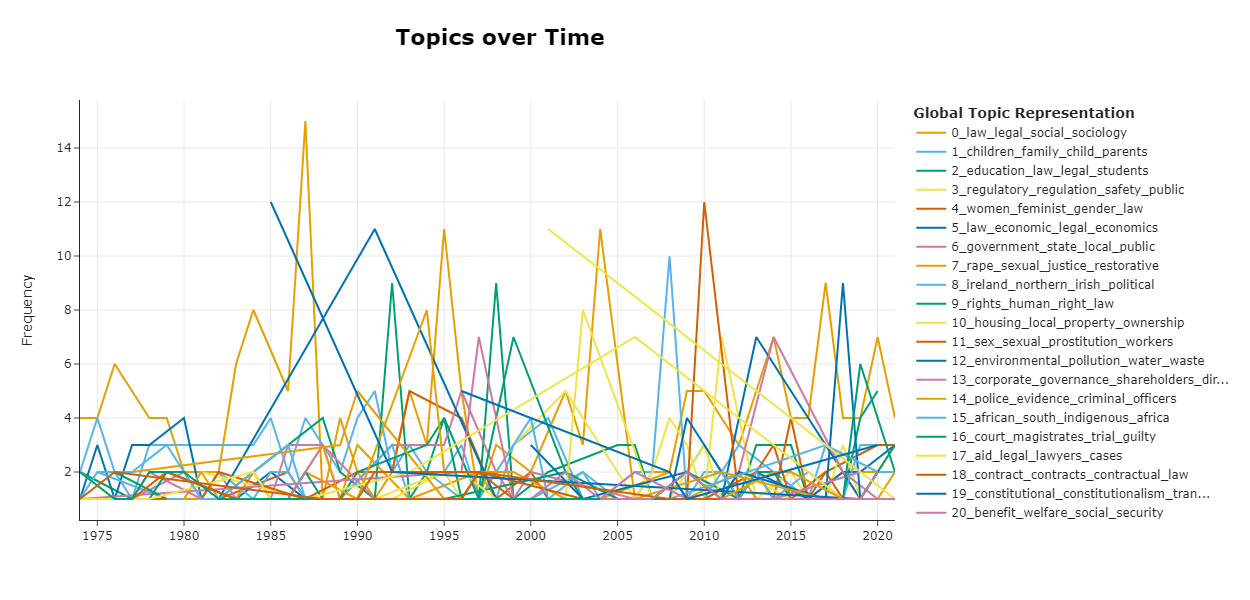

In [19]:
if 'topics_over_time' not in locals():
    topics_over_time = model.topics_over_time(articles, timestamps)
fig = model.visualize_topics_over_time(topics_over_time)
fig.write_html("docs/jls-topics-over-time.html")
img = fig.to_image(format="png", height=600)
with open("figure/jls-topics-over-time.png", "wb") as f:
    f.write(img)
display(Image(img))

In [20]:
# created document topics, this takes a while
fig_document_topics = model.visualize_documents(articles, hide_document_hover=True)
# persist data
with open('cache/fig-document-topics.pkl', 'wb') as f:
    pickle.dump(fig_document_topics, f)

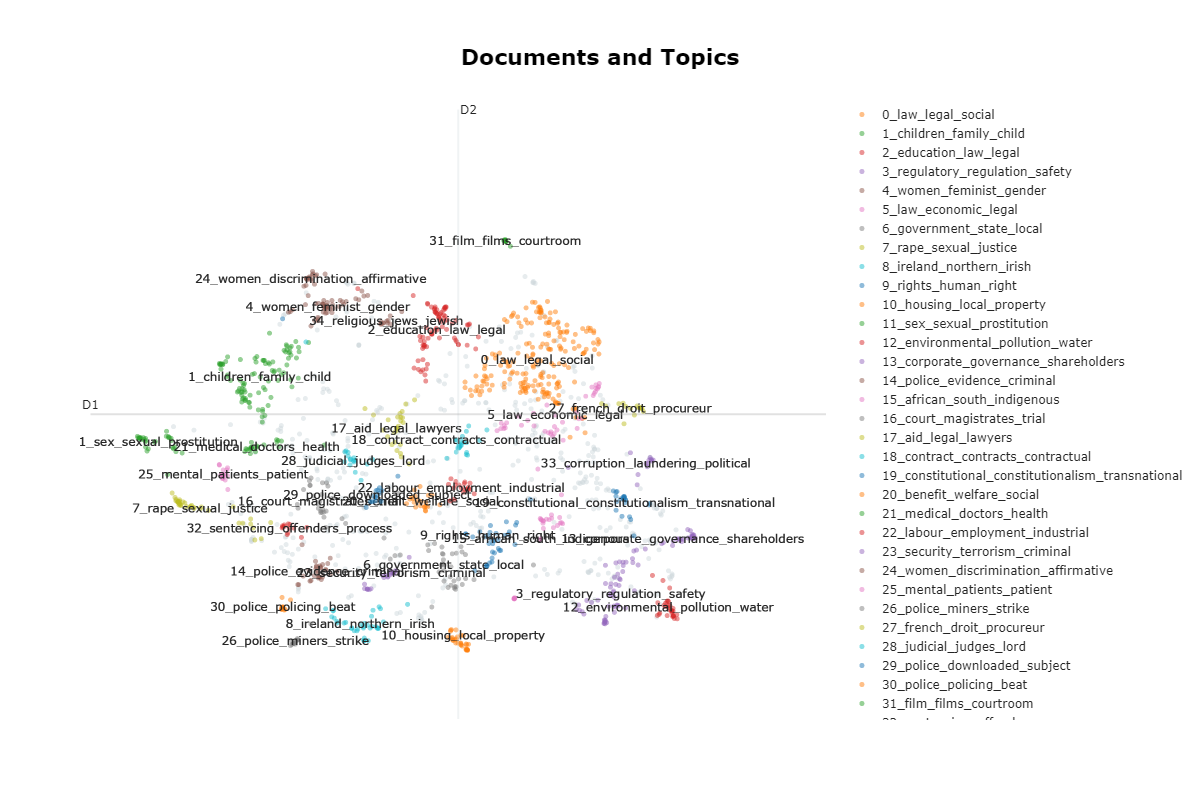

In [21]:
if 'fig_document_topics' not in locals():
    with open('cache/fig-document-topics.pkl', 'rb') as f:
        fig_document_topics = pickle.load(f)
img = fig_document_topics.to_image(format="png", height=800)
with open("figure/jls-document-topics.png", "wb") as f:
    f.write(img)
fig_document_topics.write_html("docs/jls-document-topics.html")
display(Image(img))